In [1]:
import warnings
warnings.filterwarnings("ignore")

# Gathering, analysing and visualizing the data

Navigating to the dataset and unzipping it for use

In [ ]:
!wget https://www.dropbox.com/s/ccuzosua1d1ed7n/COVID-19_Radiography_Dataset.zip?dl=0

In [ ]:
!unzip /content/COVID-19_Radiography_Dataset.zip?dl=0

Importing necessary libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import shutil
import glob

Storing the path of the root directory, a directory named "all_images" where we will copy all the images 

Also creating an array

In [5]:
ROOT_DIR="/content/COVID-19_Radiography_Dataset/"
images=["COVID","Normal"]

NEW_DIR="/content/all_images/"

Copying all the images to the new directory created

In [6]:
if not os.path.exists(NEW_DIR):
  os.mkdir(NEW_DIR)

for i in images:
    org_dir = os.path.join(ROOT_DIR, i+"/")
    
    for imgfile in glob.iglob(os.path.join(org_dir, "*.png")):
      shutil.copy(imgfile, NEW_DIR)
      
else:
  print("Folder already exists")

Folder already exists


Getting the total count of the two different types of images

In [7]:
counter = {'COVID':0,'Normal':0}

for image in images:
  for count in glob.iglob(NEW_DIR+image+"*"):
    counter[image] += 1

counter

{'COVID': 3616, 'Normal': 10192}

Visualizing the image count

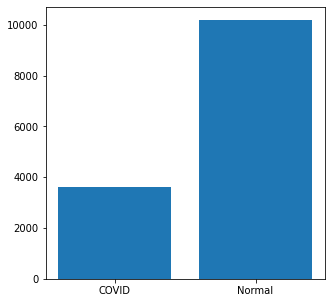

In [8]:
plt.figure(figsize=(5,5))
plt.bar(x = counter.keys(), height= counter.values())
plt.show()


# Data Splitting

First, we create a sub-directory within 'all_images' where we split the data into 3 sets: Training data, Testing data and Validation Data.

**Total COVID Samples = 3616**

**Total Normal Samples = 10192**

Total number of Normal samples is much more than the COVID samples, so we will only consider 3600 images for the divisions.

The division of images is as follows:

**Training data contains 2500 COVID Samples and 2500 Normal Samples**

**Testing data contains 100 COVID Samples and 100 Normal Samples**

**Validation data contains 1000 COVID Samples and 1000 Normal Samples**

The division is such that we proceed with 3600 images of both the classes.

In [9]:
if not os.path.exists(NEW_DIR+"train_test_split/"):

  os.makedirs(NEW_DIR+"train_test_split/")

  os.makedirs(NEW_DIR+"train_test_split/train/Normal")
  os.makedirs(NEW_DIR+"train_test_split/train/Covid")

  os.makedirs(NEW_DIR+"train_test_split/test/Normal")
  os.makedirs(NEW_DIR+"train_test_split/test/Covid")

  os.makedirs(NEW_DIR+"train_test_split/validation/Normal")
  os.makedirs(NEW_DIR+"train_test_split/validation/Covid")

  # Training Data
  for i in np.random.choice(replace= False , size= 2500 , a = glob.glob(NEW_DIR+images[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 2500 , a = glob.glob(NEW_DIR+images[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Normal" )
    os.remove(i)

 # Validation Data
  for i in np.random.choice(replace= False , size= 1000 , a = glob.glob(NEW_DIR+images[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 1000 , a = glob.glob(NEW_DIR+images[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Normal" )
    os.remove(i)

# Test Data
  for i in np.random.choice(replace= False , size= 100 , a = glob.glob(NEW_DIR+images[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 100 , a = glob.glob(NEW_DIR+images[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Normal" )
    os.remove(i)

Storing the paths of the directories in which we splitted the data into 3 variables

In [10]:
train_path  = "/content/all_images/train_test_split/train"
valid_path  = "/content/all_images/train_test_split/validation"
test_path   = "/content/all_images/train_test_split/test"

# Data Augmentation

Importing deep learning layers and models

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from keras.models import Model
from keras.layers import Flatten , Dense, Dropout , MaxPool2D
import keras

Keras provides the ImageDataGenerator class that defines the configuration for image data preparation and augmentation. We will be using this class for all 3 types of data.

For training our model, we will be including some augmentation like zooming, horizontal flipping and shearing such that the model is trained on all forms of image data.

In [12]:
train_data_gen = ImageDataGenerator(preprocessing_function= preprocess_input, 
                                    zoom_range= 0.2, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2
                                    
                                    ) # preprocess_input transforms a standard image into an appropriate input (0 or 1 in our case)

train = train_data_gen.flow_from_directory(directory= train_path, 
                                           target_size=(224,224))

Found 5000 images belonging to 2 classes.


In [13]:
validation_data_gen = ImageDataGenerator(preprocessing_function= preprocess_input  )

valid = validation_data_gen.flow_from_directory(directory= valid_path, 
                                                target_size=(224,224))

Found 2000 images belonging to 2 classes.


In [14]:
test_data_gen = ImageDataGenerator(preprocessing_function= preprocess_input )

test = train_data_gen.flow_from_directory(directory= test_path , 
                                          target_size=(224,224), 
                                          shuffle= False)

Found 200 images belonging to 2 classes.


In [15]:
class_type = {0:'Covid',  1:'Normal'}

In [16]:
t_img , label = train.next()

In [17]:
def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """

  for im, l in zip(img_arr,label) :
    plt.figure(figsize= (5,5))
    plt.imshow(im,cmap='gray')
    plt.title(im.shape)
    plt.axis = False
    plt.show()

In [ ]:
plotImages(t_img, label)

# Our Model: ResNet50

Schematic Diagram of ResNet50 model

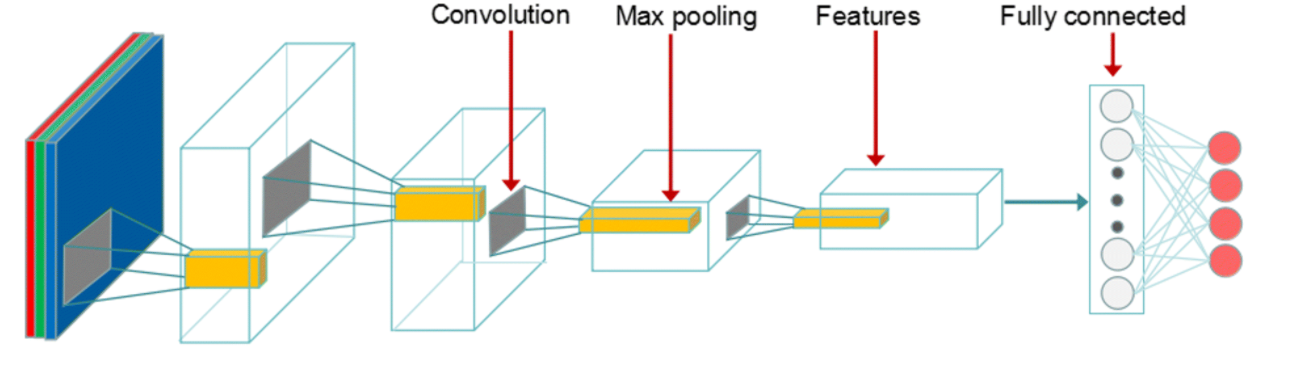

Instantiating the ResNet50 architecture

We won't include the fully connected layer at the top. So, we set the respective parameter to false.

In [19]:
res = ResNet50( input_shape=(224,224,3), include_top= False)

94781440/94765736 [==============================] - 1s 0us/step


Since ResNet50 is a pre-trained model, we won't train the parameters again

In [20]:
for layer in res.layers:           
  layer.trainable = False

Getting the list, type and shape of the layers

After all the layers have been applied, the result is a multi-dimensional matrix. We must transform this into a matrix that is in the shape of the required output.

Flatten Layer flattens the input images.

Dense layer classifies the images based on output from convolutional layers.

In [21]:
x = Flatten()(res.output)
x = Dense(units=2 , activation='sigmoid', name = 'predictions' )(x)


model = Model(res.input, x)

The Model class groups layers into an object with training and inference features.

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [23]:
model = Model(inputs = res.input, outputs = x)

The compile method configures the model for training.

In [24]:
model.compile( optimizer= 'adam' , loss = 'binary_crossentropy', metrics=['accuracy'])

# Training the model

**EarlyStopping** class stops the model from training when a monitored metric has stopped improving. Here, we monitor validation accuracy.

**min_delta:**  Minimum change in the monitored quantity to qualify as an improvement

**patience:** Number of epochs with no improvement after which training will be stopped.


**ModelCheckpoint** class is used to save the model for later use.

**save_best_only= True** : saves when the model is considered the "best" 

In [25]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

Training the model with suitable parameters. Here, we train the model for 30 epochs.

In [26]:
hist = model.fit_generator(train, steps_per_epoch= 10, epochs= 30, validation_data= valid , validation_steps= 16, callbacks=[es,mc])

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 6.3793 - accuracy: 0.6844
Epoch 1: val_accuracy improved from -inf to 0.82031, saving model to bestmodel.h5
10/10 [==============================] - 23s 870ms/step - loss: 6.3793 - accuracy: 0.6844 - val_loss: 4.7435 - val_accuracy: 0.8203
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 3.1959 - accuracy: 0.7969
Epoch 2: val_accuracy improved from 0.82031 to 0.86523, saving model to bestmodel.h5
10/10 [==============================] - 6s 661ms/step - loss: 3.1959 - accuracy: 0.7969 - val_loss: 1.5652 - val_accuracy: 0.8652
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.9434 - accuracy: 0.8562
Epoch 3: val_accuracy did not improve from 0.86523
10/10 [==============================] - 6s 660ms/step - loss: 1.9434 - accuracy: 0.8562 - val_loss: 1.3037 - val_accuracy: 0.8633
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 1.4796 - accuracy: 0.8406
Epoch 4: val

Load the "best" performed model

In [27]:
from keras.models import load_model
model = load_model("bestmodel.h5")

In [28]:
h = hist.history

In [29]:
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Performance Evaluation

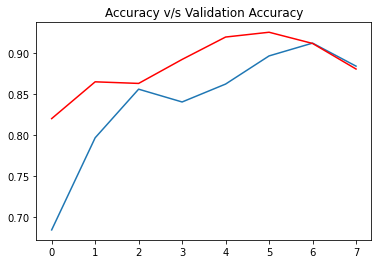

In [30]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("Accuracy v/s Validation Accuracy")
plt.show()

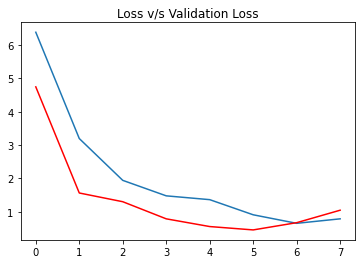

In [31]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("Loss v/s Validation Loss")
plt.show()

Obtaining the accuracy of our model on the testing data

In [32]:
acc = model.evaluate_generator(generator= test)[1] 

print(f"Model Accuracy = {acc*100} %")

Model Accuracy = 87.99999952316284 %


# Testing the model on random images

In [33]:
from keras.preprocessing import image
import matplotlib.cm as cm

from IPython.display import Image, display

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

In [34]:
def save_and_display_gradcam(img_path , heatmap, cam_path="cam.jpg", alpha=0.4):
    """
    img input shoud not be expanded 
    """

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [35]:
def image_prediction_and_visualization(path,last_conv_layer_name = "conv5_block3_3_conv", model = model):
  """
  input:  is the image path, name of last convolution layer , model name
  output : returs the predictions and the area that is effected
  """
  
  img_array = get_img_array(path)

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  plt.title("Heatmap of the CXR Image ")
  plt.imshow(heatmap)
  plt.show()
  print()
  img = get_img_array(path)

  res = class_type[np.argmax(model.predict(img))]
  print(f"The given X-Ray image is of type = {res}")
  print()
  print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} %")
  print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} %")

  print()
  print("Heatmap representing infected regions")

  # function call
  save_and_display_gradcam(path, heatmap)


In [36]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

The CXR image is of type: Covid

The chances of CXR Iamge being a COVID Sample is : 99.99980926513672 %

The chances of CXR Image being Normal is : 0.30428864993155 %



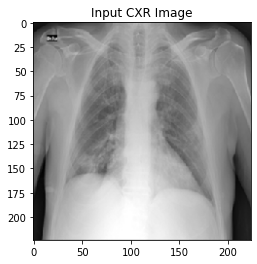

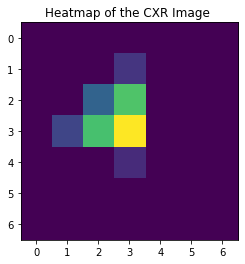


The given X-Ray image is of type = Covid

The chances of image being Covid is : 99.99980926513672 %
The chances of image being Normal is : 0.30428864993155 %

Heatmap representing infected regions


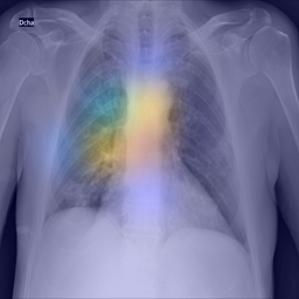

In [41]:
import tensorflow as tf

path = "/content/all_images/train_test_split/validation/Covid/COVID-12.png"       


img = get_img_array(path)

res = class_type[np.argmax(model.predict(img))]
print(f"The CXR image is of type: {res}")
print()
print(f"The chances of CXR Iamge being a COVID Sample is : {model.predict(img)[0][0]*100} %")
print()
print(f"The chances of CXR Image being Normal is : {model.predict(img)[0][1]*100} %")
print()
 
plt.imshow(img[0]/255, cmap = "gray")
plt.title("Input CXR Image")

plt.show()
print()

image_prediction_and_visualization(path)